In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import sys
sys.path.append("..")

import jax
import jax.numpy as jnp
from jax import vmap, jit
import haiku as hk

In [2]:
from evosax.problems.bernoulli_bandit import reset, step
from evosax.problems.bernoulli_bandit import params as env_params
from evosax.strategies.cma_es import init_strategy, ask, tell, check_termination
from evosax.utils import init_logger, update_logger, flat_to_network

# Haiku Meta-RNN

In [15]:
def lstm_policy(x):
    """ Perform single step forward through LSTM. """
    core = hk.LSTM(32)
    dense = hk.Linear(2)  
    
    counter = hk.get_state("counter", shape=[],
                           dtype=jnp.int32,
                           init=jnp.zeros)
    state = hk.get_state("state", shape=[],
                         dtype=jnp.float32,
                         init=jnp.zeros)
    if counter == 0:
        state = core.initial_state(1)
    
    x, state = core(x, state)
    x = dense(x)
    
    hk.set_state("counter", counter + 1)
    hk.set_state("state", state)
    return x


In [16]:
# Test single forward + step transition
lstm_policy = hk.transform_with_state(lstm_policy)
net_params, lstm_state = lstm_policy.init(rng_reset, jnp.expand_dims(obs, 0))
logits, lstm_state = lstm_policy.apply(net_params, lstm_state, None,
                                       jnp.expand_dims(obs, 0))
action = hk.multinomial(rng, logits, 1).squeeze()

obs, state, reward, done, _ = step(rng_step, env_params, state, action)
reward

In [40]:
from evosax.utils import get_total_params, get_network_shapes
from evosax.utils import flat_to_network, z_score_fitness
total_no_params = get_total_params(net_params)
network_shapes = get_network_shapes(net_params)
print(total_no_params, network_shapes)

4802 FrozenDict({
    lstm/linear: {
        w: (36, 128),
        b: (128,),
    },
    linear: {
        w: (32, 2),
        b: (2,),
    },
})


In [41]:
def rollout_episode(rng, net_params, env_params):
    """ Rollout a bandit episode with RNN policy. """
    rng, rng_reset, rng_net = jax.random.split(rng, 3)
    
    # Reset bandit env + placeholder network fct. (use candidate params)
    obs, state = reset(rng_reset, env_params)
    _, lstm_state = lstm_policy.init(rng_net, jnp.expand_dims(obs, 0))
    
    cum_reward = 0
    # Loop over episode timesteps and LSTM policy steps
    for t in range(env_params["max_steps"]):
        # Generate rng keys for action sampling and step transition
        rng, rng_action, rng_step = jax.random.split(rng, 3)
        # Perform forward through RNN and sample action
        logits, lstm_state = lstm_policy.apply(net_params, lstm_state,
                                               None,
                                               jnp.expand_dims(obs, 0))
        action = hk.multinomial(rng_action, logits, 1).squeeze()
        # Perform step transition
        obs, state, reward, done, _ = step(rng_step, env_params,
                                           state, action)
        cum_reward += reward
    return cum_reward

In [42]:
ep_reward = rollout_episode(rng, net_params, env_params)
ep_reward, env_params

(DeviceArray(58, dtype=int32), FrozenDict({
     sample_probs: DeviceArray([0.1, 0.9], dtype=float32),
     num_arms: 2,
     max_steps: 100,
 }))

In [43]:
# Jitting fails because of counter hidden init boolean
# fast_rollout = jit(rollout_episode, static_argnums=(2,))
# fast_rollout(rng, net_params, env_params)

In [44]:
# Batch over different evaluation episodes
batch_rollout = vmap(rollout_episode, in_axes=(0, None, None), out_axes=0)
batch_keys = jax.random.split(rng, 10)
ep_rewards = batch_rollout(batch_keys, net_params, env_params)
ep_rewards

DeviceArray([40, 44, 38, 59, 66, 43, 43, 58, 44, 65], dtype=int32)

In [45]:
def reshape_and_eval(rng, x, network_shapes, env_params):
    """ Perform both parameter reshaping and evaluation in one go. """
    net_params = flat_to_network(x, network_shapes)
    returns = batch_rollout(rng, net_params, env_params)
    return - returns.mean()

x = jnp.zeros(total_no_params)
reshape_and_eval(batch_keys, x, network_shapes, env_params)

DeviceArray(-51.1, dtype=float32)

In [46]:
generation_fitness = vmap(reshape_and_eval, in_axes=(None, 0, None, None))
xs = jnp.stack([x, x])
generation_fitness(batch_keys, xs, network_shapes, env_params)

DeviceArray([-51.1, -51.1], dtype=float32)

In [49]:
# Run Open-NES
num_generations = 10
pop_size = 10
elite_size = 5
mean_init = jnp.zeros((total_no_params, ))
sigma_init = 1
params, memory = init_strategy(mean_init, sigma_init,
                               pop_size, elite_size)
fit = []
for g in range(num_generations):
    # Explicitly handle random number generation
    rng, rng_ask, rng_eval = jax.random.split(rng, 3)
    batch_keys = jax.random.split(rng_eval, 10)
    # Ask for the next generation population to test
    x, memory = ask(rng_ask, params, memory)
    # Evaluate the fitness of the generation members
    #fitness = batch_rosenbrock(x, 1, 100) 
    fitness = generation_fitness(batch_keys, x,
                                 network_shapes, env_params)
    fit.append(fitness.min())
    print("Episode return:", fit[-1])
    # x, fitness = rank_shaped_fitness(x, fitness)
    # Tell/Update the CMA-ES with newest data points
    memory = tell(x, fitness, params, memory)
    

Episode return: -57.0
Episode return: -53.2
Episode return: -58.5
Episode return: -65.8
Episode return: -50.7
Episode return: -66.9
Episode return: -57.9
Episode return: -74.6
Episode return: -60.0
Episode return: -58.4


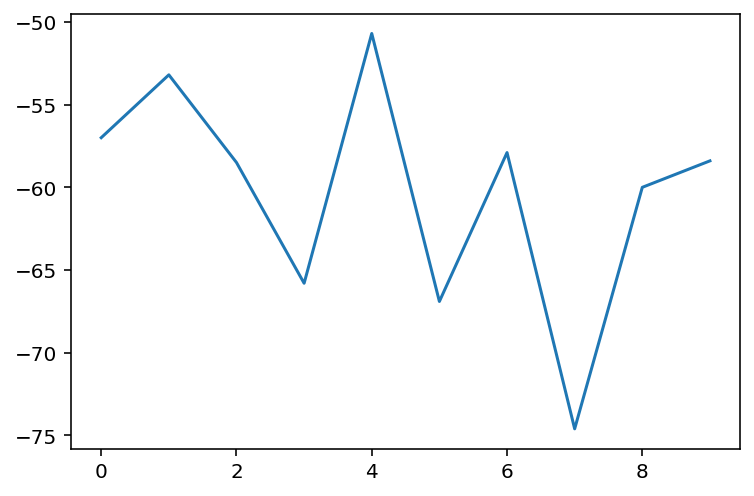

In [53]:
import matplotlib.pyplot as plt
plt.plot(fit)

In [54]:
fit

[DeviceArray(-57., dtype=float32),
 DeviceArray(-53.2, dtype=float32),
 DeviceArray(-58.5, dtype=float32),
 DeviceArray(-65.8, dtype=float32),
 DeviceArray(-50.7, dtype=float32),
 DeviceArray(-66.9, dtype=float32),
 DeviceArray(-57.9, dtype=float32),
 DeviceArray(-74.6, dtype=float32),
 DeviceArray(-60., dtype=float32),
 DeviceArray(-58.4, dtype=float32)]